#Visualize a MODFLOW Model
This notebook illustrates options for visualizing a transient model needing only to start with the appropriate MODFLOW NAM file and using `flopy` for the rest. The output in this model was created from a a model too large to include in the repository, but you can substitute any model NAM file and run it on your model.

These examples are similar to those contained in the ModelMap examples but lower level.

In [1]:
%matplotlib inline
import flopy
import flopy.utils as futils
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.backends.backend_pdf import PdfPages

###Define a plotter function
We define a simple plotter function to display fields in model row/column coordinates. No interpolation is performed so the result is the raw cell data.

In [2]:
def plotter(cmatrix, ctitle):
    '''
    Simple plotter function.
    input:
    cmatrix : matrix to plot (np.array (2D))
    ctitle : Title for the plot
    returns:
    fig : a handle to the matplotlib figure object
    ax : a handle to the matplotlib axes object
    '''
    fig = plt.figure(figsize=(10,10))
    ax = plt.gca()
    im = ax.imshow(cmatrix, interpolation='nearest', 
                   vmin = np.nanmin(cmatrix), 
                   vmax = np.nanmax(cmatrix))
    plt.title(ctitle)
    # align the colorbar with the plot rather than having it extend too high and low
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right',size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)
    return ax, fig

###We make both a Modflow model object and parse the namefile

In [3]:
m = flopy.modflow.Modflow()
nf = flopy.utils.mfreadnam.parsenamefile('transient_test_3_31_15.nam', {})
nf

Parsing the namefile --> transient_test_3_31_15.nam
Setting filehandles:
could not set filehandle for transient_test_3_31_15.lst
could not set filehandle for transient_test_3_31_15.cbb
could not set filehandle for transient_test_3_31_15.ddn


{1: <flopy.utils.mfreadnam.NamData at 0x106447210>,
 7: <flopy.utils.mfreadnam.NamData at 0x106447110>,
 11: <flopy.utils.mfreadnam.NamData at 0x106447310>,
 12: <flopy.utils.mfreadnam.NamData at 0x1064470d0>,
 13: <flopy.utils.mfreadnam.NamData at 0x106447450>,
 14: <flopy.utils.mfreadnam.NamData at 0x106447550>,
 18: <flopy.utils.mfreadnam.NamData at 0x1064474d0>,
 19: <flopy.utils.mfreadnam.NamData at 0x106447590>,
 22: <flopy.utils.mfreadnam.NamData at 0x106447610>,
 27: <flopy.utils.mfreadnam.NamData at 0x106447050>,
 29: <flopy.utils.mfreadnam.NamData at 0x106447290>,
 30: <flopy.utils.mfreadnam.NamData at 0x106447850>,
 31: <flopy.utils.mfreadnam.NamData at 0x106447710>,
 40: <flopy.utils.mfreadnam.NamData at 0x106447390>,
 50: <flopy.utils.mfreadnam.NamData at 0x1063fbfd0>}

###Using the namefile, we can load any package by type
In `flopy.utils.mfreadnam` is a method `getfiletypeunit` that returns the unit number associated with a package by type. This allows general code to load a package without needing to directly know its filename

In [4]:
disfilename = nf[futils.mfreadnam.getfiletypeunit(nf,'dis')].filename
dis = flopy.modflow.ModflowDis.load(disfilename, m, nf)
print 'Reading DIS from {0}'.format(disfilename)
upwfilename = nf[futils.mfreadnam.getfiletypeunit(nf,'upw')].filename
upw = flopy.modflow.ModflowUpw.load(upwfilename, m, nf)
print 'Reading UPW from {0}'.format(upwfilename)
rchfilename = nf[futils.mfreadnam.getfiletypeunit(nf,'rch')].filename
rch = flopy.modflow.ModflowRch.load(rchfilename, m, ext_unit_dict=nf, nper=None)
print 'Reading RCH from {0}'.format(rchfilename)


Reading DIS from transient_test_3_31_15.dis
Reading UPW from transient_test_3_31_15.upw
Reading RCH from transient_test_3_31_15.rch


In [5]:
basfilename = nf[futils.mfreadnam.getfiletypeunit(nf,'bas6')].filename
bas = flopy.modflow.ModflowBas.load(basfilename, m, ext_unit_dict=nf)

###Once packages are loaded, we can explore and plot
For example, we can take all `ibound` values in layer 1 not equal to -1 and set them to `np.nan` to isolate and plot the constant head boundary cells.

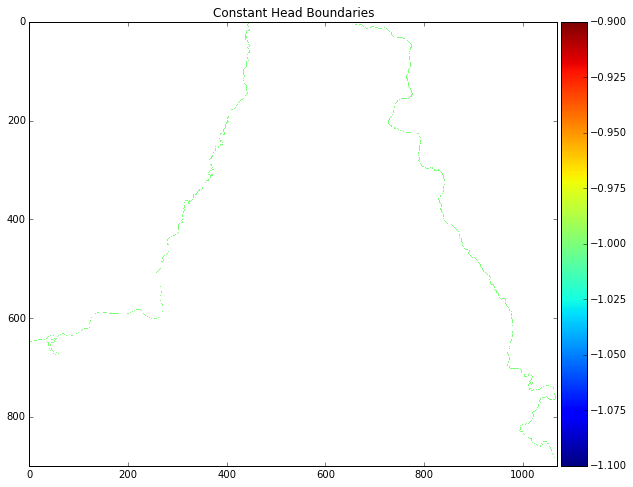

In [6]:
tmp_ib_1 = bas.ibound[0,:,:].copy().astype(float)
tmp_ib_1[tmp_ib_1 != -1] = np.nan
fig,ax = plotter(tmp_ib_1, 'Constant Head Boundaries')


In [7]:
tmp_ib_1.astype(float)

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

###Optionally, put out matrix files for importing into a GUI or whatnot

In [8]:
ofp_HK = open('HK.dat','w')
ofp_VKA = open('VKA.dat','w')
ofp_RCH = open('RCH.dat','w')
for clay in xrange(dis.nlay):
    print 'saving HK layer {0}'.format(clay+1)
    np.savetxt(ofp_HK, upw.hk[clay][:], fmt='%.6e', delimiter=' ', comments='')
    print 'saving VKA layer {0}'.format(clay+1)
    np.savetxt(ofp_VKA, upw.vka[clay][:], fmt='%.6e', delimiter=' ', comments='')
np.savetxt(ofp_RCH, rch.rech.transient_2ds[0][:], fmt='%.6e', delimiter=' ', comments='')
ofp_HK.close()
ofp_VKA.close()
ofp_RCH.close()

saving HK layer 1
saving VKA layer 1
saving HK layer 2
saving VKA layer 2
saving HK layer 3
saving VKA layer 3


###Print out each stress period's recharge into a multi-page PDF

In [9]:
# how many stress periods are there?
nper = dis.nper
# also, how long is each one? We can multiply out the days to get inches per month
perlen = dis.perlen

In [10]:
# loop over the stress periods and write out each recharge field as a page in the pdf
rchplots = PdfPages('RechargePlots.pdf')
for cper in xrange(nper):
    fig,ax = plotter(rch.rech.transient_2ds[cper][:]*perlen[cper]*12.0, 
                     'Recharge: in/month for SP {0}'.format(cper+1))
    #N.B. --> zero referencing on the stress periods!
    rchplots.savefig()
    plt.close() # supress screen output
rchplots.close()

###We can explore the HK, VKA arrays as well blanking high values to focus in on relevant ones

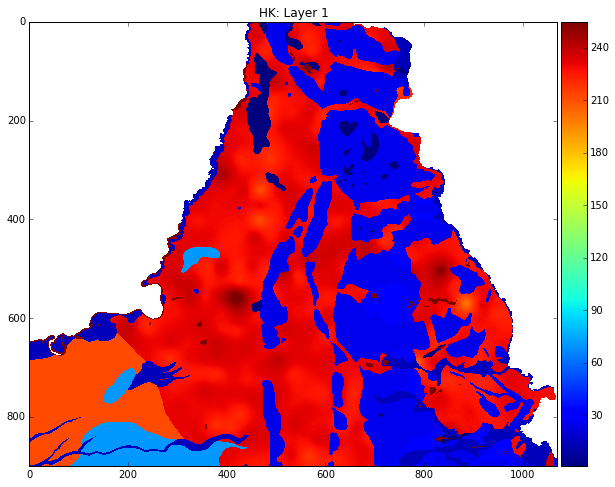

In [11]:
HK1 = upw.hk[0][:].copy()
HK1[HK1>255] = 255
HK1[HK1<0] = np.nan

fig,ax = plotter(HK1, 'HK: Layer 1')

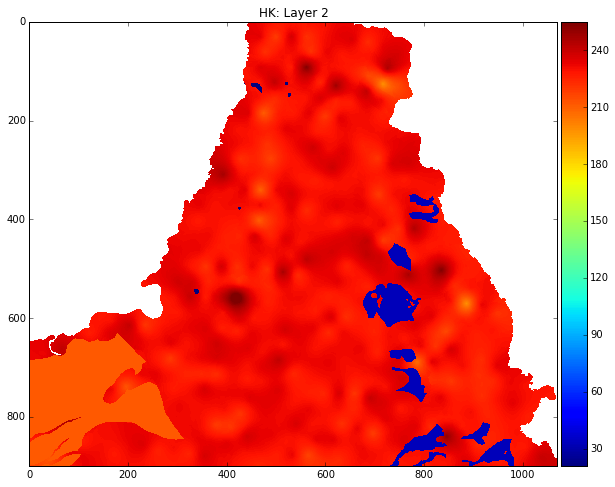

In [12]:
HK2 = upw.hk[1][:].copy()
HK2[HK2>255] = 255
HK2[HK2<2] = np.nan

fig,ax = plotter(HK2, 'HK: Layer 2')

###Plot out a multi-page PDF with each layer HK, for example

In [13]:
#how many layers?
nlay = dis.nlay

In [14]:
# loop over the layersand write out each K field as a page in the pdf
hkplots = PdfPages('HKPlots.pdf')
for clay in xrange(nlay):
    HK = upw.hk[clay][:].copy()
    HK[HK>255] = 255
    HK[HK<0] = np.nan
    fig,ax = plotter(HK, 
                     'Layer {0} HK in feet/day'.format(clay+1))
    #N.B. --> zero referencing on the layers!
    hkplots.savefig()
    plt.close() # supress screen output
hkplots.close()

###We can look at VKA in the same way

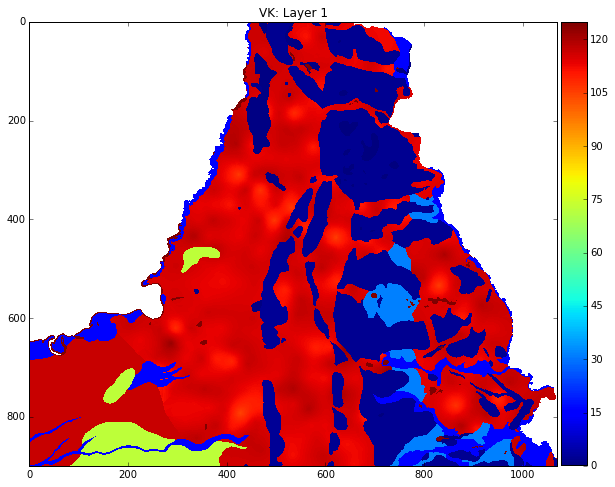

In [15]:
VK1 = upw.vka[0][:].copy()
VK1[VK1>125] = 125
VK1[VK1<0] = np.nan

fig,ax = plotter(VK1, 'VK: Layer 1')

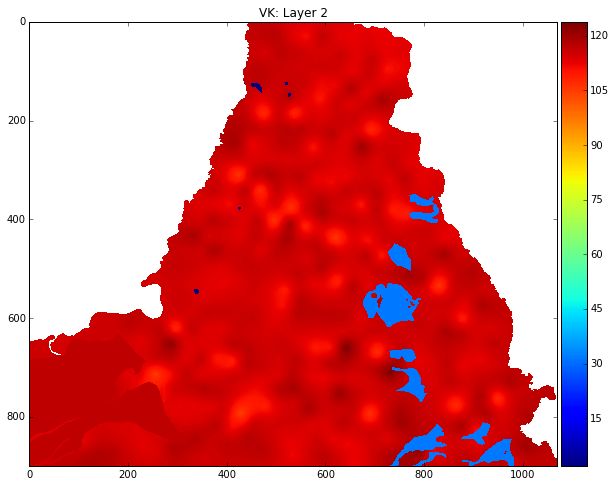

In [16]:
VK2 = upw.vka[1][:].copy()
VK2[VK2>125] = 125
VK2[VK2<0] = np.nan

fig,ax = plotter(VK2, 'VK: Layer 2')

###If we have a HDS file, can look at flooded cells

In [17]:
#open up the head file
headfile = 'transient_test_3_31_15.hds'
hdobj = flopy.utils.HeadFile(headfile)

In [18]:
times = hdobj.get_times()
floodplots = PdfPages('FloodedPlots.pdf')

for i,ct in enumerate(times):
    head = hdobj.get_data(totim=ct)
    headlay1 = head[0,:,:].copy()
    fig,ax = plotter(headlay1>dis.top[:], 'Flooded Cells (as True) for SP {0:d}  time={1:.2f}'.format(i+1,ct))
    floodplots.savefig()
    plt.close()
floodplots.close()